Simple example of U-net for segmentation in Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda

Using TensorFlow backend.
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Lam Family\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\La

In [2]:
tr = pd.read_csv('./input/train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [5]:
img_size = 256

In [6]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( './input/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [7]:
for x, y in keras_generator(4):
    break
    
print(x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 1)


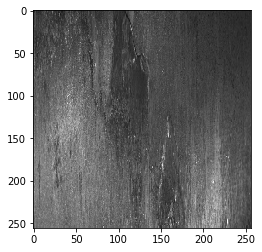

In [8]:
plt.imshow(x[3])

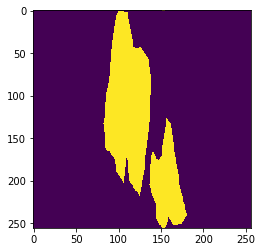

In [9]:
plt.imshow(np.squeeze(y[3]))

In [10]:
#Model

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
___________________________________________________________________________________________

In [15]:
%%time
# Fit model
batch_size = 16
results = model.fit_generator(keras_generator(batch_size), 
                              steps_per_epoch=100,
                              epochs=5) 

Epoch 1/5
100/100 [==============================] - ETA: 4:15 - loss: 0.7050 - acc: 0.594 - ETA: 2:17 - loss: 0.5564 - acc: 0.730 - ETA: 1:38 - loss: 0.4956 - acc: 0.792 - ETA: 1:18 - loss: 0.4604 - acc: 0.824 - ETA: 1:06 - loss: 0.4345 - acc: 0.845 - ETA: 58s - loss: 0.4133 - acc: 0.859 - ETA: 52s - loss: 0.3950 - acc: 0.86 - ETA: 47s - loss: 0.3797 - acc: 0.87 - ETA: 44s - loss: 0.3686 - acc: 0.88 - ETA: 41s - loss: 0.3644 - acc: 0.88 - ETA: 39s - loss: 0.3549 - acc: 0.89 - ETA: 37s - loss: 0.3477 - acc: 0.89 - ETA: 35s - loss: 0.3417 - acc: 0.89 - ETA: 33s - loss: 0.3365 - acc: 0.90 - ETA: 32s - loss: 0.3317 - acc: 0.90 - ETA: 31s - loss: 0.3271 - acc: 0.90 - ETA: 30s - loss: 0.3229 - acc: 0.90 - ETA: 29s - loss: 0.3189 - acc: 0.90 - ETA: 28s - loss: 0.3153 - acc: 0.90 - ETA: 27s - loss: 0.3118 - acc: 0.91 - ETA: 26s - loss: 0.3087 - acc: 0.91 - ETA: 26s - loss: 0.3058 - acc: 0.91 - ETA: 25s - loss: 0.3031 - acc: 0.91 - ETA: 24s - loss: 0.3005 - acc: 0.91 - ETA: 24s - loss: 0.2981 

KeyboardInterrupt: 

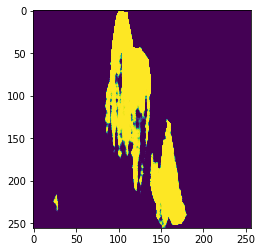

In [12]:
pred = model.predict(x)
plt.imshow(np.squeeze(pred[3]))

In [13]:
testfiles=os.listdir("../input/test_images/")
len(testfiles)

1801

In [14]:
%%time
test_img = []
for fn in tqdm_notebook(testfiles):
        img = cv2.imread( '../input/test_images/'+fn )
        img = cv2.resize(img,(img_size,img_size))       
        test_img.append(img)


CPU times: user 7.56 s, sys: 704 ms, total: 8.27 s
Wall time: 10.8 s


In [15]:
%%time
predict = model.predict(np.asarray(test_img))
print(len(predict))

1801
CPU times: user 1.52 s, sys: 2.97 s, total: 4.49 s
Wall time: 4.2 s


In [16]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [17]:
%%time
pred_rle = []
for img in predict:      
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    pred_rle.append(mask2rle(tmp))

CPU times: user 19min 22s, sys: 0 ns, total: 19min 22s
Wall time: 19min 20s


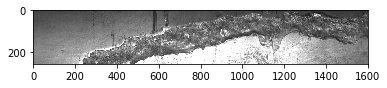

In [18]:
img_t = cv2.imread( '../input/test_images/'+ testfiles[4])
plt.imshow(img_t)

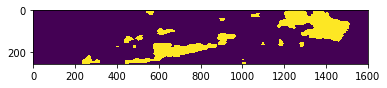

In [19]:
mask_t = rle2mask(pred_rle[4], img.shape)
plt.imshow(mask_t)

In [20]:
sub = pd.read_csv( '../input/sample_submission.csv' )
sub.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [21]:
%%time
for fn, rle in zip(testfiles, pred_rle):
    sub['EncodedPixels'][sub['ImageId_ClassId'].apply(lambda x: x.split('_')[0]) == fn] = rle

CPU times: user 12.6 s, sys: 0 ns, total: 12.6 s
Wall time: 12.5 s


In [22]:
sub.head(8)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,0 21 22 14 39 1 47 2 251 26 278 14 295 1 303 2...
1,004f40c73.jpg_2,0 21 22 14 39 1 47 2 251 26 278 14 295 1 303 2...
2,004f40c73.jpg_3,0 21 22 14 39 1 47 2 251 26 278 14 295 1 303 2...
3,004f40c73.jpg_4,0 21 22 14 39 1 47 2 251 26 278 14 295 1 303 2...
4,006f39c41.jpg_1,36327 3 36583 4 36839 4 37095 4 37351 4 37607 ...
5,006f39c41.jpg_2,36327 3 36583 4 36839 4 37095 4 37351 4 37607 ...
6,006f39c41.jpg_3,36327 3 36583 4 36839 4 37095 4 37351 4 37607 ...
7,006f39c41.jpg_4,36327 3 36583 4 36839 4 37095 4 37351 4 37607 ...


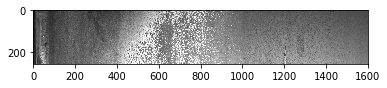

In [23]:
img_s = cv2.imread( '../input/test_images/'+ sub['ImageId_ClassId'][16].split('_')[0])
plt.imshow(img_s)

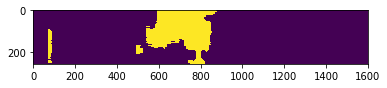

In [24]:
mask_s = rle2mask(sub['EncodedPixels'][16], (256, 1600))
plt.imshow(mask_s)

In [25]:
sub.to_csv('submission.csv', index=False)